In [3]:
import hist
from hist import Hist

import numpy as np
import awkward as ak
import uproot
import vector
vector.register_awkward()
import os
import shutil
import zipfile
import tarfile
import urllib
import requests
from tqdm import tqdm

import matplotlib.pyplot as plt

In [4]:
def _pad(a, maxlen, value=0, dtype='float32'):
    if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
        return a
    elif isinstance(a, ak.Array):
        if a.ndim == 1:
            a = ak.unflatten(a, 1)
        a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
        return ak.values_astype(a, dtype)
    else:
        x = (np.ones((len(a), maxlen)) * value).astype(dtype)
        for idx, s in enumerate(a):
            if not len(s):
                continue
            trunc = s[:maxlen].astype(dtype)
            x[idx, :len(trunc)] = trunc
        return x
    
def _download(url, fname, chunk_size=1024):
    '''https://gist.github.com/yanqd0/c13ed29e29432e3cf3e7c38467f42f51'''
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get('content-length', 0))
    with open(fname, 'wb') as file, tqdm(
        desc=fname,
        total=total,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=chunk_size):
            size = file.write(data)
            bar.update(size)

In [5]:
def _pad(a, maxlen, value=0, dtype='float32'):
    if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
        return a
    elif isinstance(a, ak.Array):
        if a.ndim == 1:
            a = ak.unflatten(a, 1)
        a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
        return ak.values_astype(a, dtype)
    else:
        x = (np.ones((len(a), maxlen)) * value).astype(dtype)
        for idx, s in enumerate(a):
            if not len(s):
                continue
            trunc = s[:maxlen].astype(dtype)
            x[idx, :len(trunc)] = trunc
        return x

In [6]:
example_file = 'JetClass_example_100k.root'
example_file2 = 'HToWW2Q1L_100.root'

tree = uproot.open(example_file)['tree']

table = tree.arrays()

feat_list = ['part_px', 'part_py', 'part_pz', 'part_energy', 'part_deta', 'part_dphi', 'part_d0val', 'part_d0err', 'part_dzval', 'part_dzerr', 'part_charge', 'part_isChargedHadron', 'part_isNeutralHadron', 'part_isPhoton', 'part_isElectron', 'part_isMuon']
label_list = ['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']

In [7]:
part_px = table['part_px']
print(part_px[0], len(part_px[0])) 
part_px_pad =_pad(part_px, maxlen=128).to_numpy()
print(part_px_pad[0], len(part_px_pad[0]))

[-125, -91.1, -83.2, -68.9, -66.8, ..., -1.51, -1.47, -1.48, -1.19, -1.14] 38
[-124.57671    -91.08083    -83.18519    -68.85736    -66.77691
  -41.19437    -39.766884   -35.645782   -20.00814    -18.28535
  -17.367708   -15.411278   -12.29248    -11.373656   -10.828111
  -11.373961   -10.786323    -7.6682477   -7.382622    -7.358262
   -6.4391284   -5.3729844   -3.7339034   -3.7424257   -3.5270748
   -2.918364    -2.9014804   -2.8357656   -1.7878695   -2.4975572
   -2.348407    -1.9714551   -1.5660105   -1.5133526   -1.4652246
   -1.4823993   -1.1863252   -1.1423494    0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.        

In [19]:
data =table[feat_list[11]]
print(feat_list[11])
label = table[label_list[0]].to_numpy()
mask = data[label == 1]
print(mask)

part_isChargedHadron
[[0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, ..., 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0], ...]


part_px 0
part_py 1
part_pz 2
part_energy 3
part_deta 4
part_dphi 5
part_d0val 6
part_d0err 7
part_dzval 8
part_dzerr 9
part_charge 10
part_isChargedHadron 11
part_isNeutralHadron 12
part_isPhoton 13
part_isElectron 14
part_isMuon 15


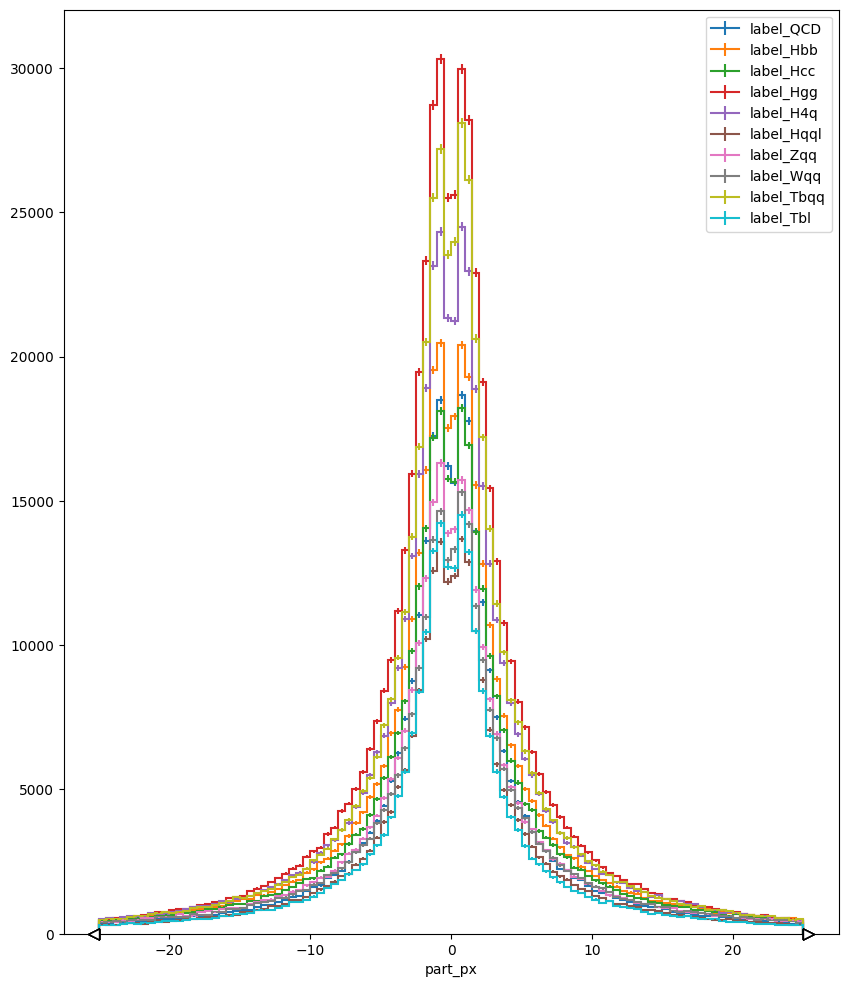

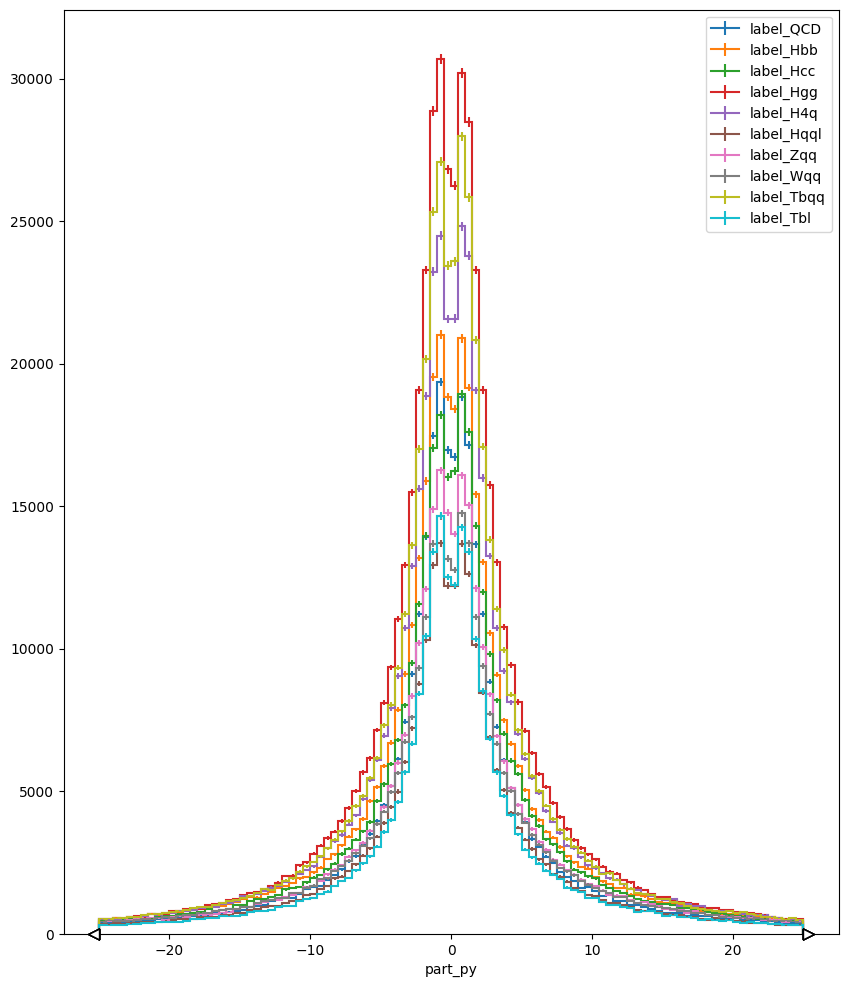

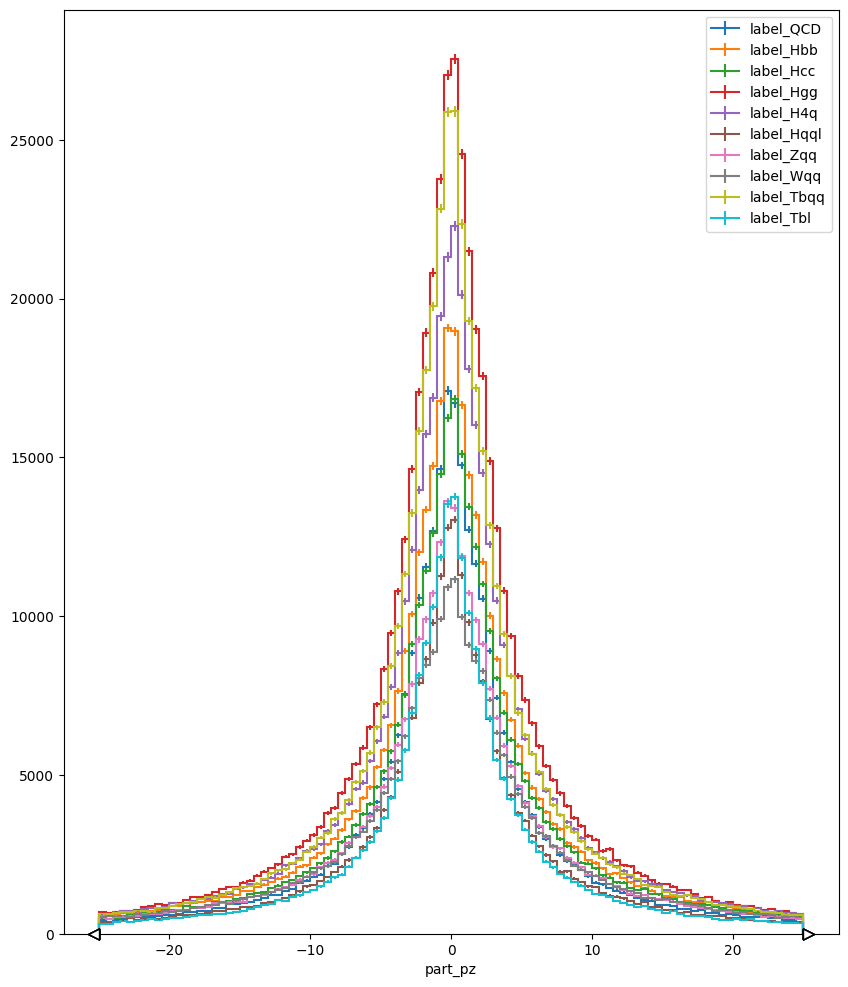

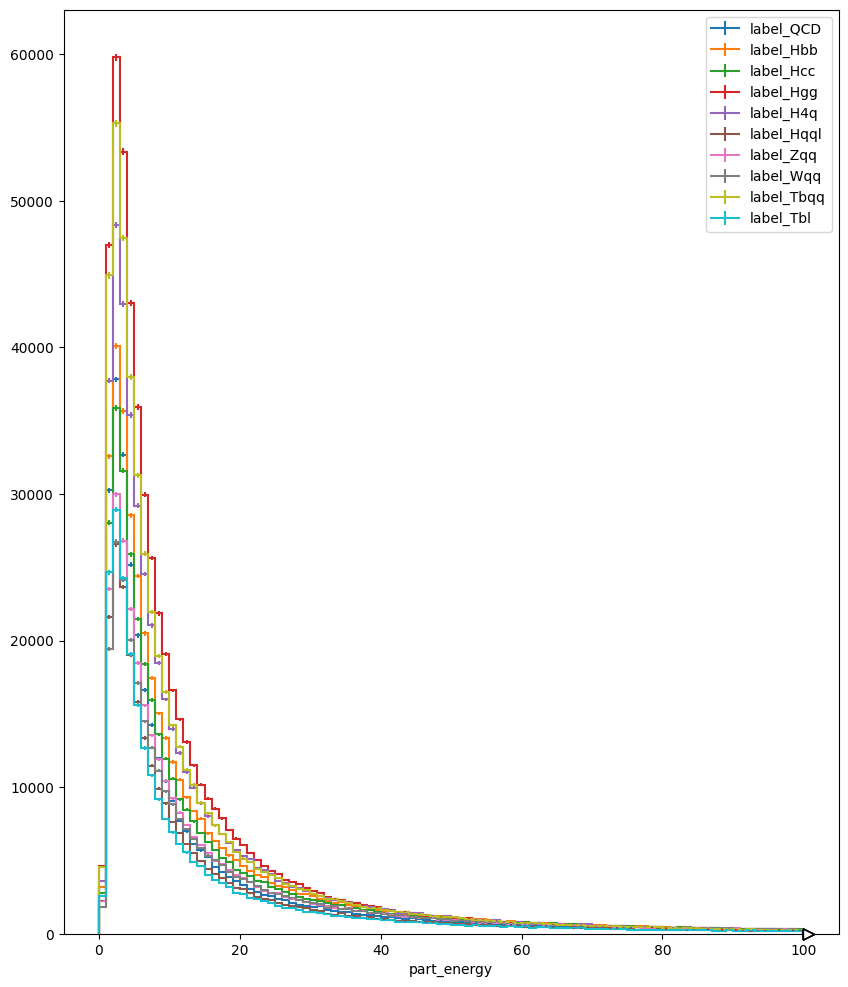

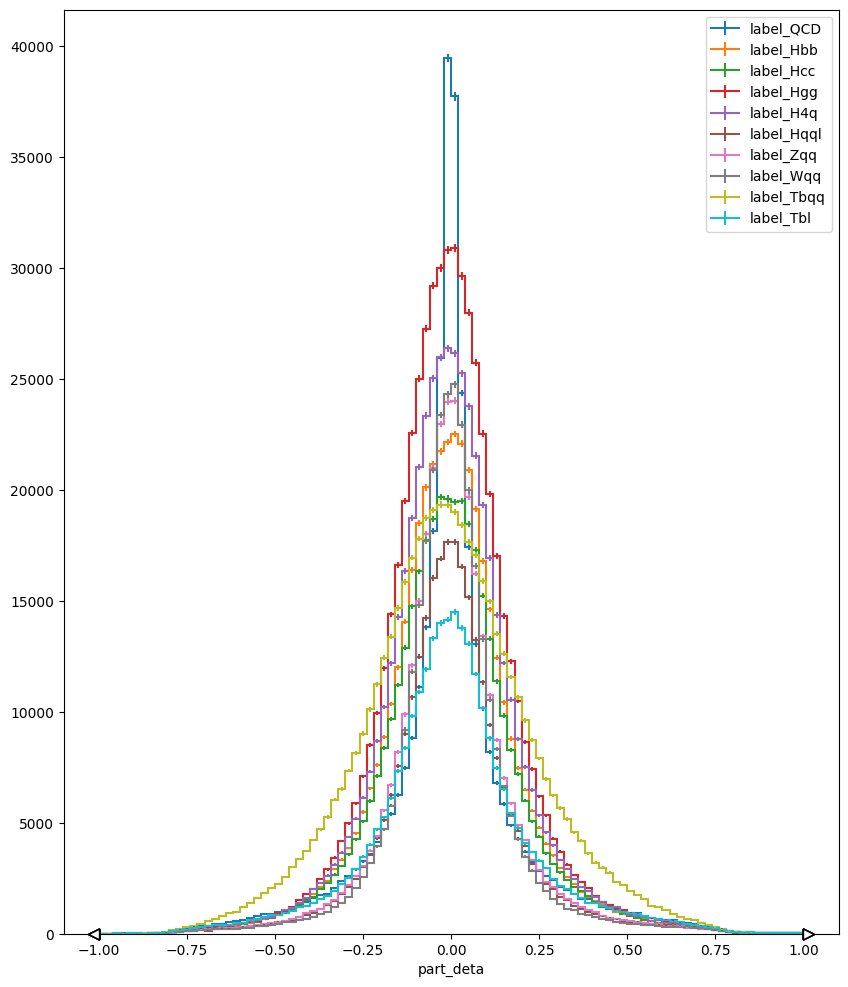

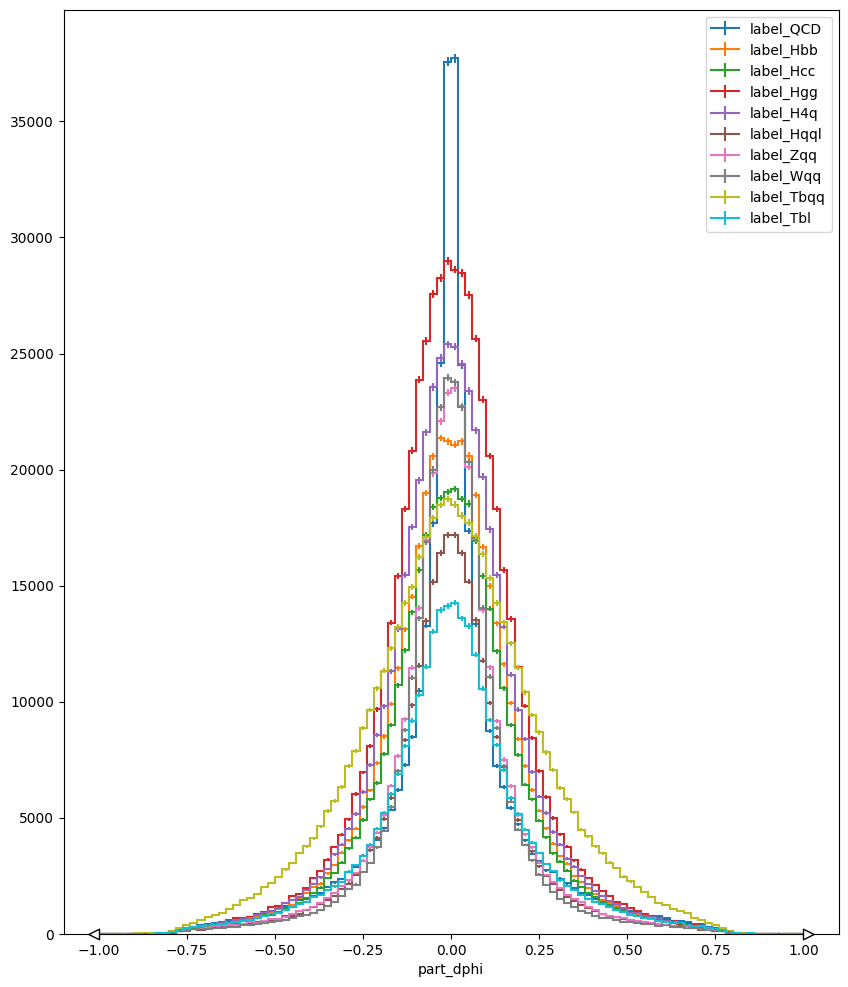

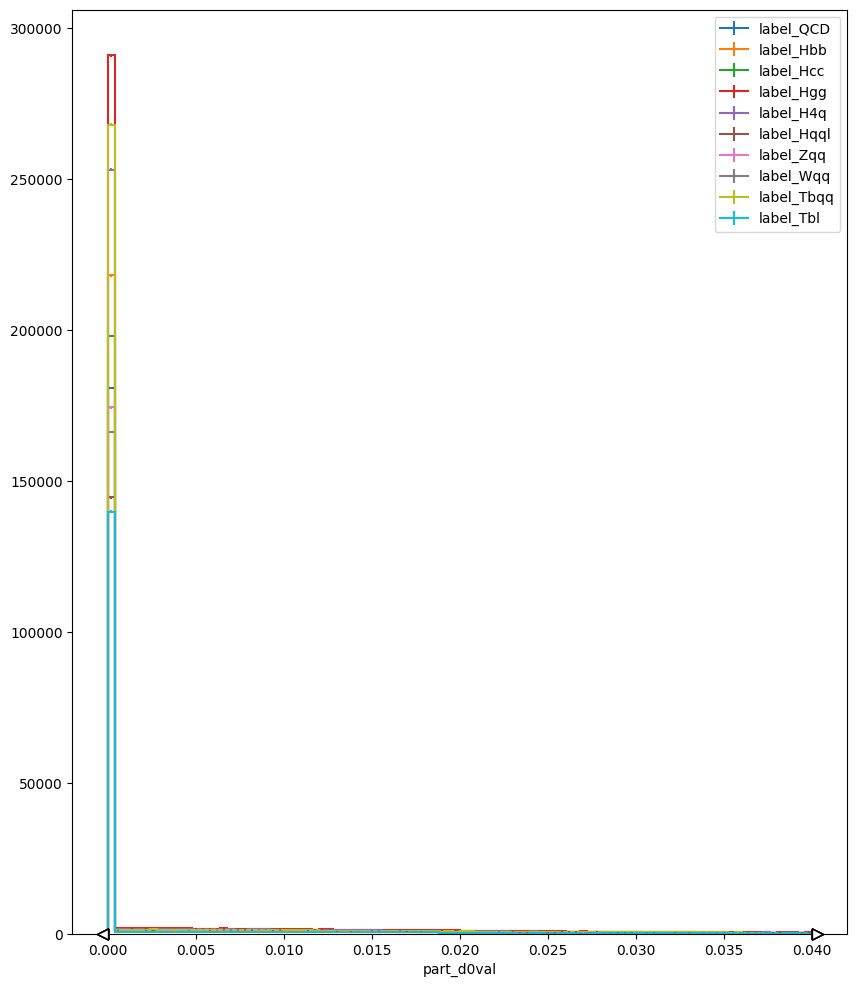

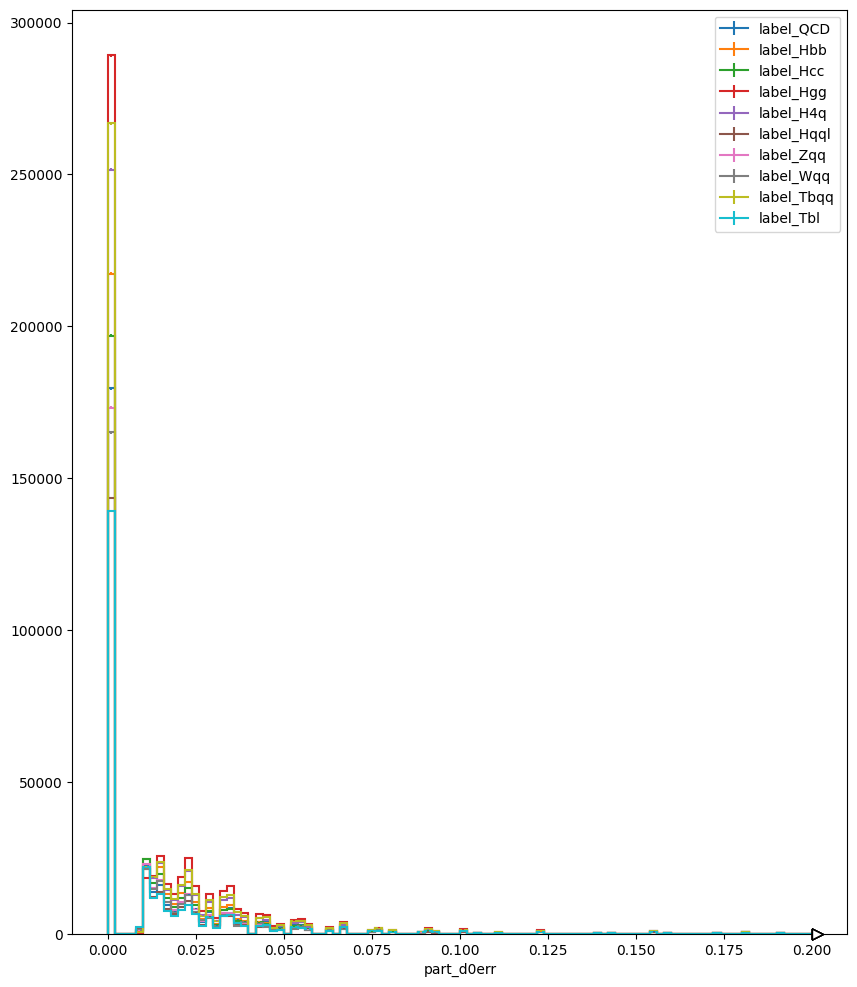

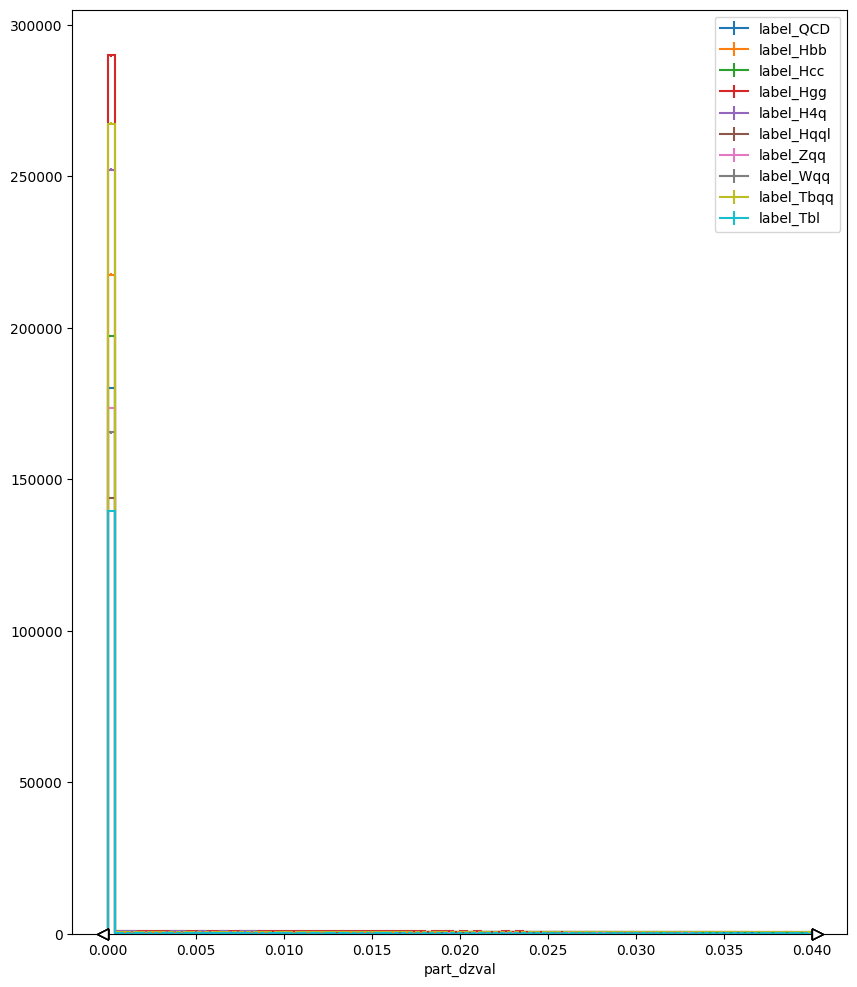

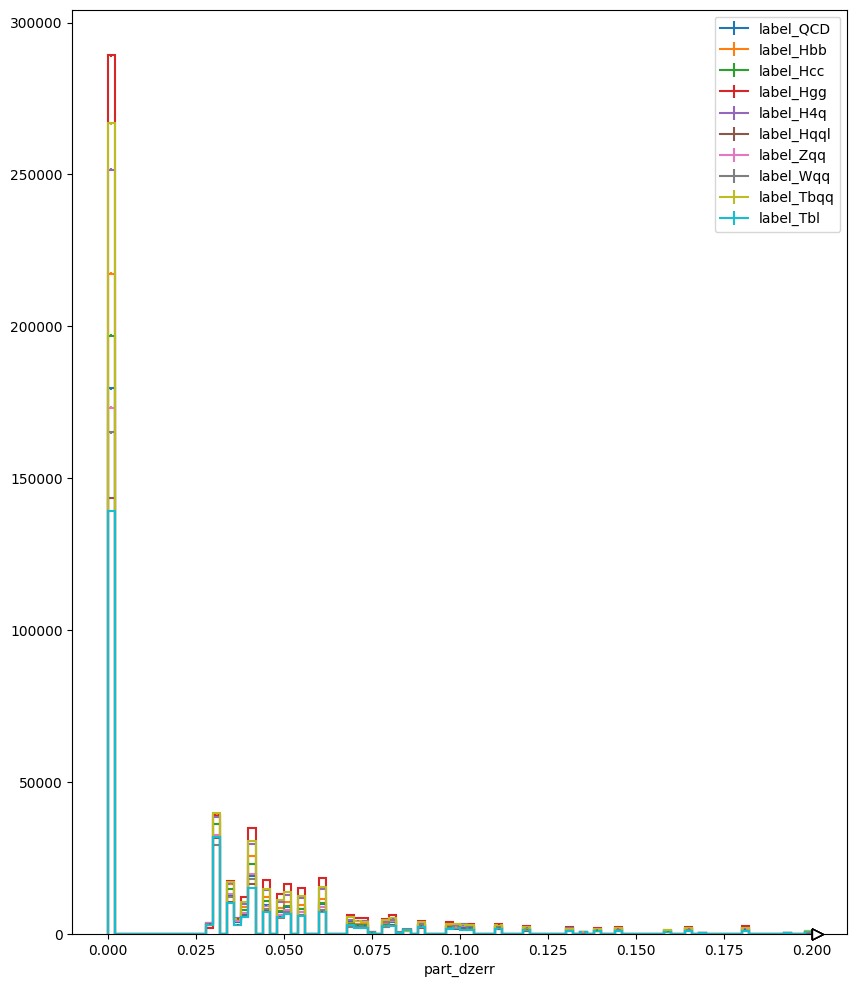

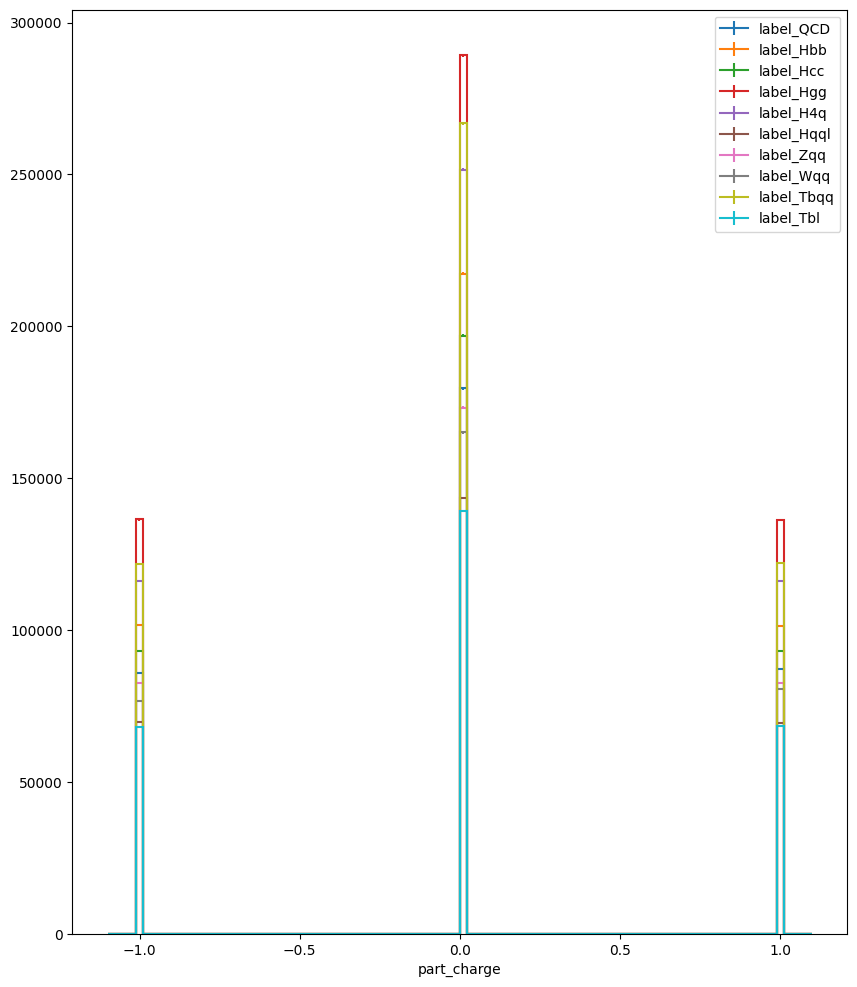

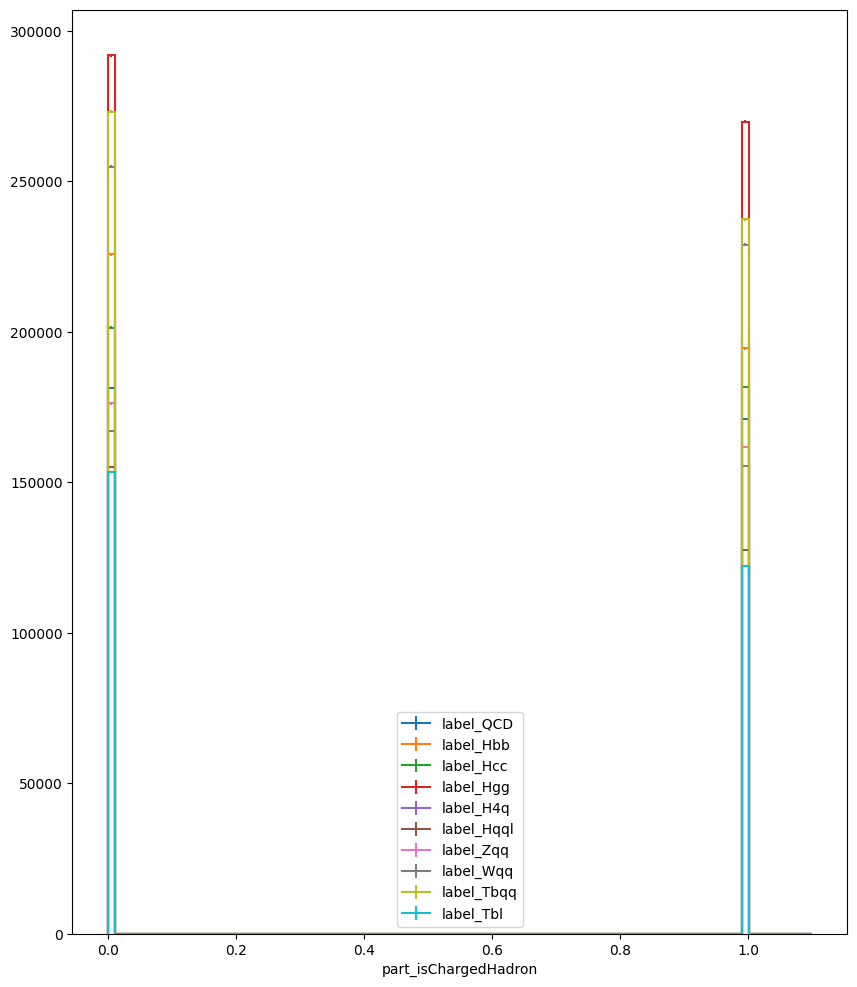

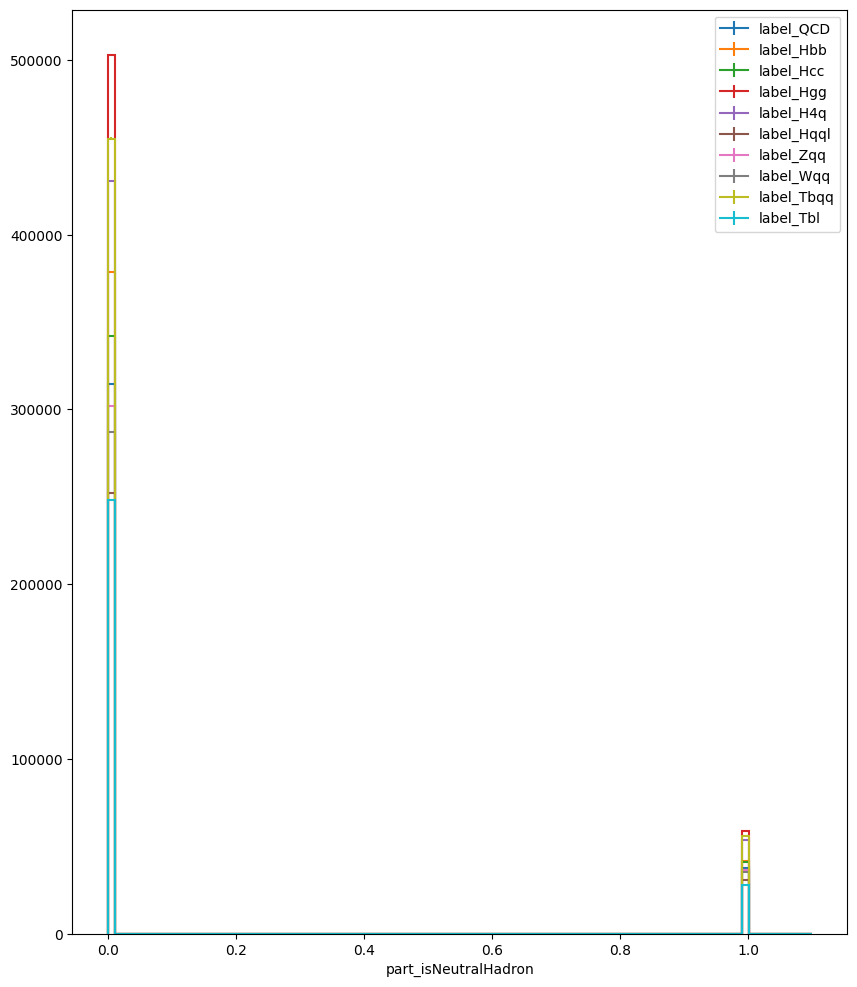

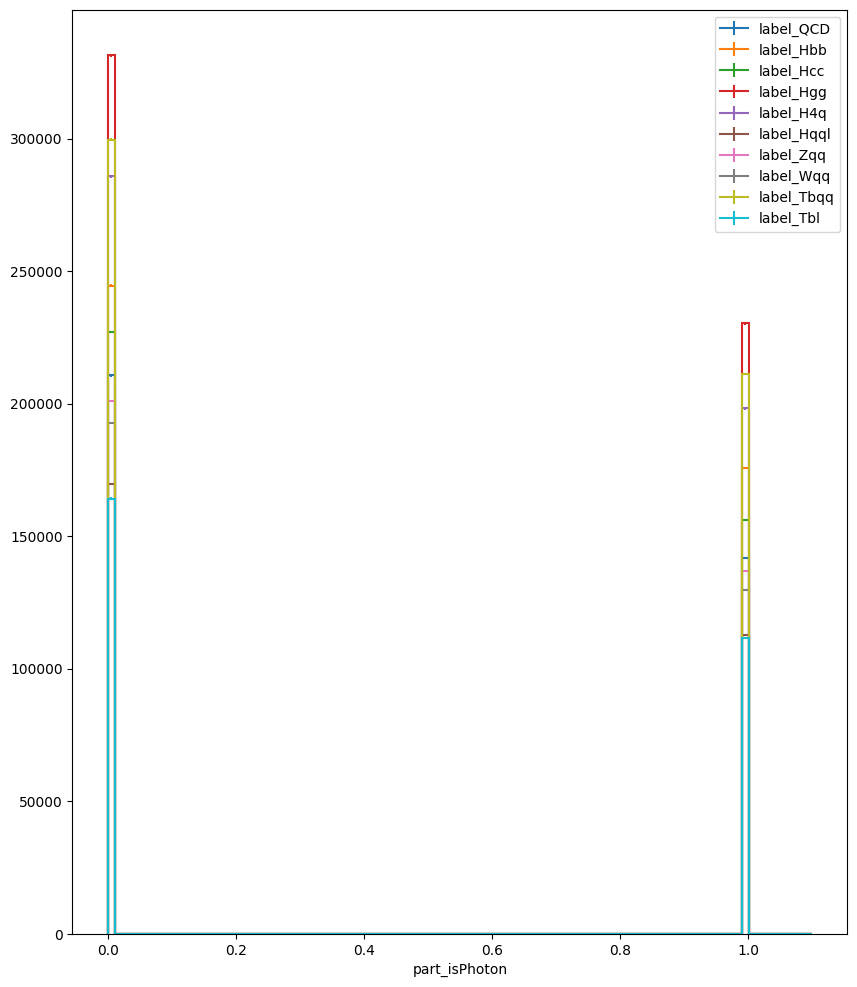

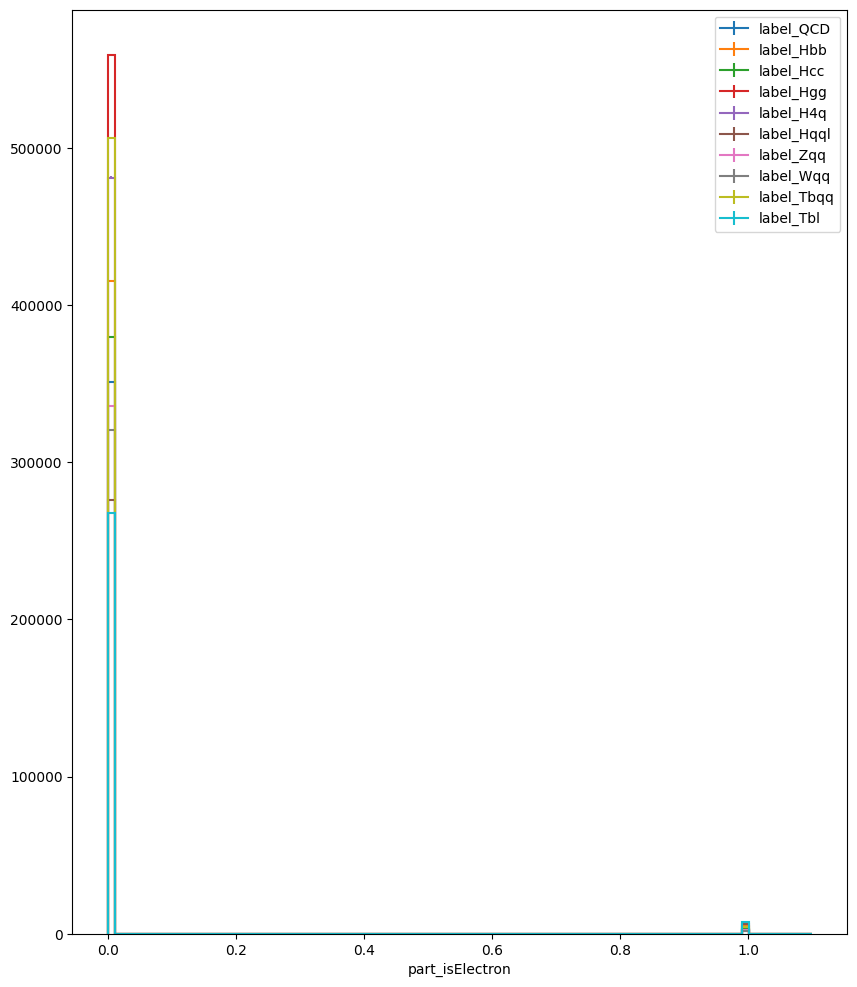

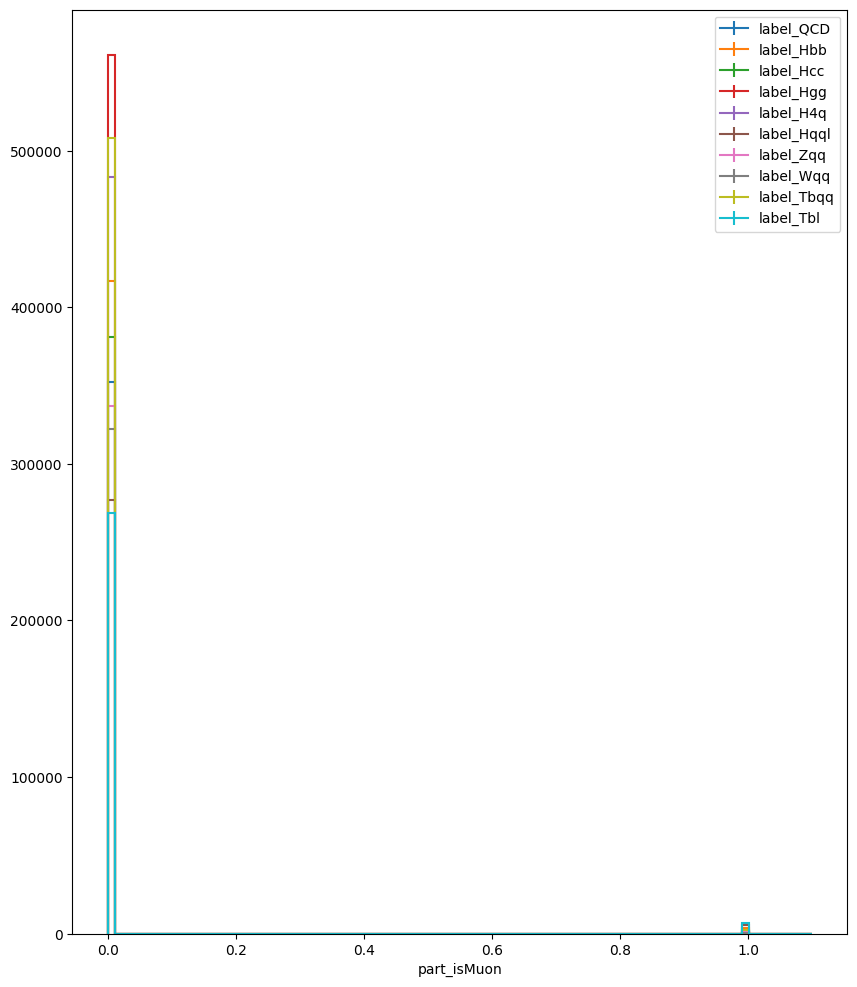

In [28]:
for k in range(len(feat_list)):
    print(feat_list[k], k)
    bin_num = 100
    start_num = 0
    stop_num = 1000
    if(k<3):
        bin_num = 100
        start_num = -25
        stop_num = 25
    elif(k==3):
        stop_num = 100
    elif(k==4 or k==5):
        start_num = -1
        stop_num = 1
    elif(k==6 or k == 8):
        start_num = 0
        stop_num = 0.04
    elif(k==7 or k == 9):
        start_num = 0
        stop_num = 0.2
    elif(k==10):
        start_num = -1.1
        stop_num = 1.1
    else:
        stop_num = 1.1
    hpt = hist.Hist(
        hist.axis.Regular(bins= bin_num, start=start_num, stop =stop_num, label= feat_list[k], name= feat_list[k]),
        hist.axis.StrCategory(label_list, name="labels", label=label_list),
    )
    data = table[feat_list[k]]
    # data = _pad(data,maxlen=128).to_numpy()
    for j in range(len(label_list)): 
        label = table[label_list[j]].to_numpy()
        mask = data[label == 1]
        for i in range(len(mask)):
            hpt.fill(mask[i], labels = label_list[j])
            
    fig, ax = plt.subplots(figsize=(10,12))
    # hpt[{"labels": label_list[0]}].plot1d(ax=ax, label = label_list[0])
    for i in range(len(label_list)):
        hpt[{"labels": label_list[i]}].plot1d(ax=ax, label = label_list[i])
    ax.legend()
    plt.savefig('part_plots/' + feat_list[k] + '.png')

IndexError: list index out of range

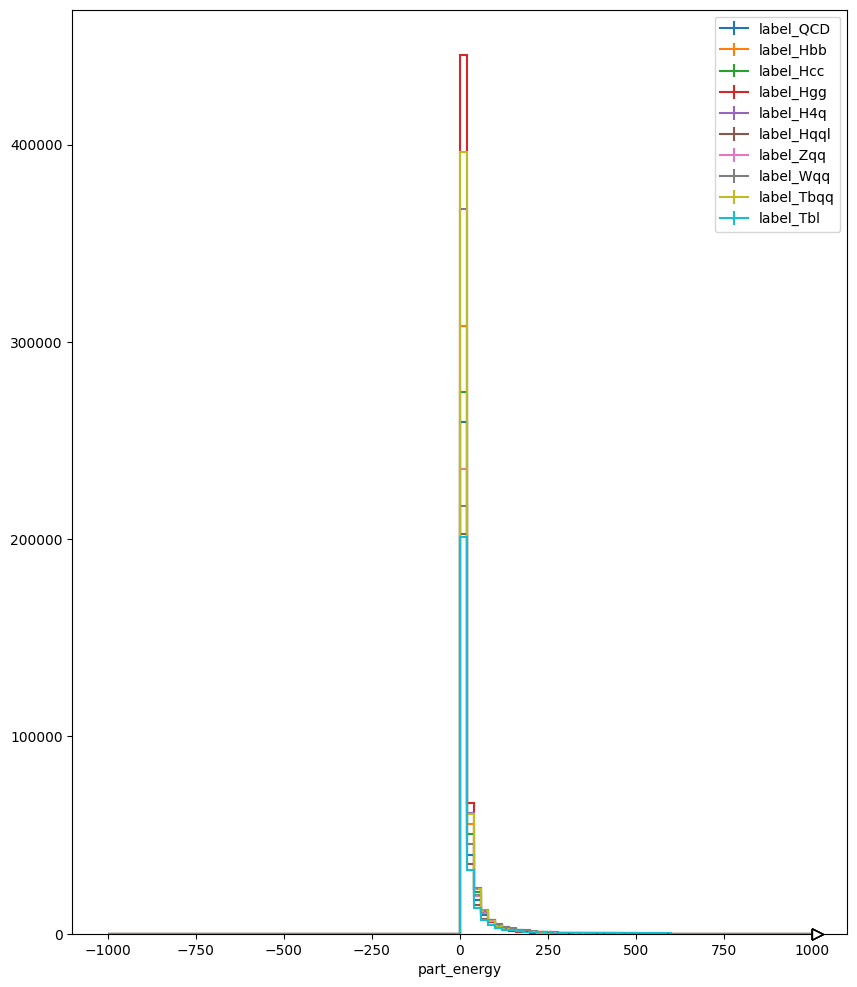

In [ ]:
print(feat_list[0])

part_px
